In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
import pickle as pkl

In [5]:
dtypes = pkl.load(open("dtypes_data_with_metadata.pkl", "rb"))
df = pd.read_csv("data_with_metadata.csv", dtype=dtypes)
df["EncodedPixels"] = df.EncodedPixels.apply(eval)
df.loc[df["PatientAge"] > 100, "PatientAge"] = 60
df.head()

,ImageId,EncodedPixels,fp,empty,mean,new_mean,empty_area,mean_without_empty,Modality,ConversionType,...,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,mask_sum
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,[-1],../data/raw/dicom-images-train/1.2.276.0.72300...,True,169.965969,-4.336809e-18,0,169.965969,CR,WSD,...,1024,1024,0.168,8,8,7,0,01,ISO_10918_1,0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,[-1],../data/raw/dicom-images-train/1.2.276.0.72300...,True,71.922405,-1.526557e-16,358243,109.245984,CR,WSD,...,1024,1024,0.139,8,8,7,0,01,ISO_10918_1,0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,[-1],../data/raw/dicom-images-train/1.2.276.0.72300...,True,155.955172,1.821460e-17,1620,156.196488,CR,WSD,...,1024,1024,0.168,8,8,7,0,01,ISO_10918_1,0
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,[-1],../data/raw/dicom-images-train/1.2.276.0.72300...,True,125.845778,-4.163336e-17,7486,126.750677,CR,WSD,...,1024,1024,0.139,8,8,7,0,01,ISO_10918_1,0
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,[-1],../data/raw/dicom-images-train/1.2.276.0.72300...,True,125.757782,1.457168e-16,1231,125.905592,CR,WSD,...,1024,1024,0.168,8,8,7,0,01,ISO_10918_1,0


In [6]:
len(df)

10675

In [22]:
((df["mask_sum"] < 1500) & (df["mask_sum"] > 0.5)).sum()

143

In [10]:
df.columns

Index(['ImageId', 'EncodedPixels', 'fp', 'empty', 'mean', 'new_mean',
       'empty_area', 'mean_without_empty', 'Modality', 'ConversionType',
       'PatientName', 'PatientID', 'PatientSex', 'PatientAge',
       'BodyPartExamined', 'ViewPosition', 'SeriesNumber', 'InstanceNumber',
       'PatientOrientation', 'SamplesPerPixel', 'PhotometricInterpretation',
       'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored',
       'HighBit', 'PixelRepresentation', 'LossyImageCompression',
       'LossyImageCompressionMethod', 'mask_sum'],
      dtype='object')

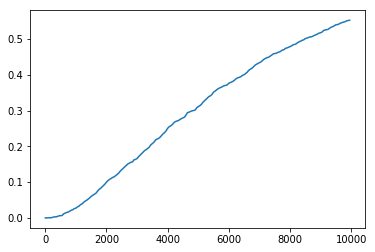

In [32]:
sample_df = df[~df["empty"]]
plot_data = []
for thresh in np.arange(0, 10000, 50):
    plot_data.append([thresh, (sample_df["mask_sum"] < thresh).mean()])
plot_data = np.array(plot_data)
plt.plot(plot_data[:, 0], plot_data[:, 1])

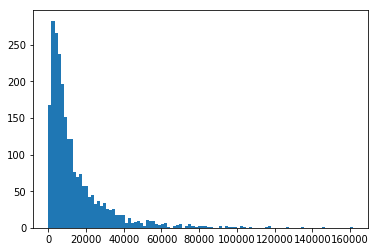

In [46]:
sample_df = df[~df["empty"]]
plt.hist(sample_df["mask_sum"], bins=100);

In [49]:
sample_df = df[~df["empty"]]["mask_sum"]
labels = pd.qcut(sample_df, 10, labels=False)
# labels.value_counts()
for label in sorted(labels.unique()):
    print(label, sample_df[labels == label].mean())

0 1296.609243697479
1 2732.7125
2 4060.5974576271187
3 5578.14705882353
4 7386.794117647059
5 9870.582278481013
6 13156.40756302521
7 18493.470588235294
8 27236.235294117647
9 53630.445378151264


In [66]:
validation_size = 600

In [100]:
np.random.seed(69)
X = df["ImageId"].values
mask_sum = df["mask_sum"].values
y = np.ones(len(X), dtype=np.int) * 10
labels = pd.qcut(mask_sum[mask_sum > 0.5], 10, labels=False)
y[mask_sum > 0.5] = labels
# y = y != 10
indeces = np.arange(len(y))
val_indeces = []
get_from_bucket = (validation_size // 2) // len(np.unique(labels))
for cls in range(0, 10):
    val_indeces += np.random.choice(indeces[y == cls], size=get_from_bucket, replace=False).tolist()
val_indeces += np.random.choice(indeces[y == 10], size=validation_size - len(val_indeces), replace=False).tolist()
train_indeces = []
set_val_indeces = set(val_indeces)
for i in indeces:
    if i not in set_val_indeces:
        train_indeces.append(i)
np.random.shuffle(train_indeces)
np.random.shuffle(val_indeces)

np.save("../split/train.npy", X[train_indeces])
np.save("../split/validation.npy", X[val_indeces])

print(val_indeces[:10])
print(train_indeces[:10])

[1205, 2472, 5539, 7397, 3746, 544, 9392, 9703, 5072, 3914]
[9609, 7614, 3231, 2905, 3372, 8870, 3062, 6691, 6803, 6441]


In [104]:
(y == 10)[val_indeces].sum()

300

In [105]:
X[train_indeces]

array(['1.2.276.0.7230010.3.1.4.8323329.4817.1517875184.963295',
       '1.2.276.0.7230010.3.1.4.8323329.32483.1517875160.802853',
       '1.2.276.0.7230010.3.1.4.8323329.12968.1517875242.785063', ...,
       '1.2.276.0.7230010.3.1.4.8323329.5185.1517875186.867502',
       '1.2.276.0.7230010.3.1.4.8323329.11093.1517875230.991870',
       '1.2.276.0.7230010.3.1.4.8323329.2262.1517875171.857099'],
      dtype=object)

In [118]:
np.mean(np.ones((5, 1, 5)), axis=0, keep_dims=True).shape

TypeError: mean() got an unexpected keyword argument 'keep_dims'

# For Bodya

In [122]:
csv_path = "../data/siim-dataset/train-rle.csv"
df = pd.read_csv(csv_path)
df = df.groupby("ImageId").first().reset_index()
df["Label"] = df[' EncodedPixels'] != ' -1'

train_image_ids = np.load("../split/train.npy", allow_pickle=True)
val_image_ids = np.load("../split/validation.npy", allow_pickle=True)

train_csv = df[df["ImageId"].isin(train_image_ids)].reset_index(drop=True)
val_csv = df[df["ImageId"].isin(val_image_ids)].reset_index(drop=True)

In [129]:
import os

In [130]:
train_csv["Path"] = train_csv.ImageId.apply(lambda x: os.path.join("/datasets/processed_512/img/", "{}.png".format(x)))
val_csv["Path"] = val_csv.ImageId.apply(lambda x: os.path.join("/datasets/processed_512/img/", "{}.png".format(x)))

In [132]:
cols = ["Label", "Path"]
train_csv[cols].to_csv("bodya_train.csv", index=None)
val_csv[cols].to_csv("bodya_val.csv", index=None)

In [134]:
thresh_list = np.arange(0.15, 0.9999, 0.025)
min_area_list = np.arange(100, 6000, 100)
len(thresh_list) * len(min_area_list) * 3 / 60.0

100.3

In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class OfficialBinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(OfficialBinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        targets = targets.float()
        pos = (targets > 0.5).float()
        neg = (targets < 0.5).float()
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        F_loss = self.alpha * pos * F_loss + (1 - self.alpha) * neg * F_loss
        return torch.mean(F_loss)

In [170]:
loss = OfficialBinaryFocalLoss(alpha=.25)

In [173]:
inp = torch.tensor([
    [
        [
            [0.45, 0.45],
            [0.45, 0.45]
        ]
    ],
    [
        [
            [0.45, 0.45],
            [0.45, 0.45]
        ]
    ]
])
out = torch.zeros(2, 1, 2, 2)
out[1, 0, 0, 0] = 1

In [186]:
BCE_loss = F.binary_cross_entropy_with_logits(inp, out, reduce=False)

In [182]:
torch.exp(torch.tensor(-10.0))

tensor(4.5400e-05)

In [174]:
loss(inp , out)

tensor(0.2332)

In [159]:
alpha = torch.Tensor([0.15, 1-0.15])
alpha.gather(0,out.long().view(-1))

tensor([0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8500])

In [162]:
0.09 ** (3/4)

0.16431676725154984

In [164]:
thresh_list = np.arange(0.40, 0.9999, 0.05)
min_area_list = np.arange(1500, 6000, 100)
len(thresh_list) * len(min_area_list) * 3/60

24.0

In [199]:
import numbers

import torch

from ignite.metrics import Metric, MetricsLambda
from ignite.exceptions import NotComputableError
from ignite.utils import to_onehot


class ConfusionMatrix(Metric):
    """Calculates confusion matrix for multi-class data.

    - `update` must receive output of the form `(y_pred, y)`.
    - `y_pred` must contain logits and has the following shape (batch_size, num_categories, ...)
    - `y` can be of two types:
        - shape (batch_size, num_categories, ...)
        - shape (batch_size, ...) and contains ground-truth class indices

    Args:
        num_classes (int): number of classes. In case of images, num_classes should also count the background index 0.
        average (str, optional): confusion matrix values averaging schema: None, "samples", "recall", "precision".
            Default is None. If `average="samples"` then confusion matrix values are normalized by the number of seen
            samples. If `average="recall"` then confusion matrix values are normalized such that diagonal values
            represent class recalls. If `average="precision"` then confusion matrix values are normalized such that
            diagonal values represent class precisions.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.
    """

    def __init__(self, num_classes, average=None, output_transform=lambda x: x):
        if average is not None and average not in ("samples", "recall", "precision"):
            raise ValueError("Argument average can None or one of ['samples', 'recall', 'precision']")

        self.num_classes = num_classes
        self._num_examples = 0
        self.average = average
        self.confusion_matrix = None
        super(ConfusionMatrix, self).__init__(output_transform=output_transform)

    def reset(self):
        self.confusion_matrix = torch.zeros(self.num_classes, self.num_classes, dtype=torch.float)
        self._num_examples = 0

    def _check_shape(self, output):
        y_pred, y = output

        if y_pred.ndimension() < 2:
            raise ValueError("y_pred must have shape (batch_size, num_categories, ...), "
                             "but given {}".format(y_pred.shape))

        if y_pred.shape[1] != self.num_classes:
            raise ValueError("y_pred does not have correct number of categories: {} vs {}"
                             .format(y_pred.shape[1], self.num_classes))

        if not (y.ndimension() == y_pred.ndimension() or y.ndimension() + 1 == y_pred.ndimension()):
            raise ValueError("y_pred must have shape (batch_size, num_categories, ...) and y must have "
                             "shape of (batch_size, num_categories, ...) or (batch_size, ...), "
                             "but given {} vs {}.".format(y.shape, y_pred.shape))

        y_shape = y.shape
        y_pred_shape = y_pred.shape

        if y.ndimension() + 1 == y_pred.ndimension():
            y_pred_shape = (y_pred_shape[0],) + y_pred_shape[2:]

        if y_shape != y_pred_shape:
            raise ValueError("y and y_pred must have compatible shapes.")

        return y_pred, y

    def update(self, output):
        y_pred, y = self._check_shape(output)

        if y_pred.shape != y.shape:
            y_ohe = to_onehot(y.reshape(-1), self.num_classes)
            y_ohe_t = y_ohe.transpose(0, 1).float()
        else:
            y_ohe_t = y.transpose(1, -1).reshape(y.shape[1], -1).float()

        indices = torch.argmax(y_pred, dim=1)
        y_pred_ohe = to_onehot(indices.reshape(-1), self.num_classes)
        y_pred_ohe = y_pred_ohe.float()

        if self.confusion_matrix.type() != y_ohe_t.type():
            self.confusion_matrix = self.confusion_matrix.type_as(y_ohe_t)

        self.confusion_matrix += torch.matmul(y_ohe_t, y_pred_ohe).float()
        self._num_examples += y_pred.shape[0]

    def compute(self):
        if self._num_examples == 0:
            raise NotComputableError('Confusion matrix must have at least one example before it can be computed.')
        if self.average:
            if self.average == "samples":
                return self.confusion_matrix / self._num_examples
            elif self.average == "recall":
                return self.confusion_matrix / (self.confusion_matrix.sum(dim=1) + 1e-15)
            elif self.average == "precision":
                return self.confusion_matrix / (self.confusion_matrix.sum(dim=0) + 1e-15)
        return self.confusion_matrix.cpu()

In [226]:
a = ConfusionMatrix(2)

In [227]:
z1 = torch.Tensor([0, 0, 0, 1, 1, 0, 0]).long()
                ## 1  1  0  1  0  0
z2 = torch.Tensor([
    [0, 1], #1
    [0, 1], #1
    [1, 0], #0
    [0, 1], #1
    [1, 0], #0
    [1, 0],  #0
    [0, 1], #1
])
a.update((z2, z1))

In [228]:
a.compute()

tensor([[2., 3.],
        [1., 1.]])

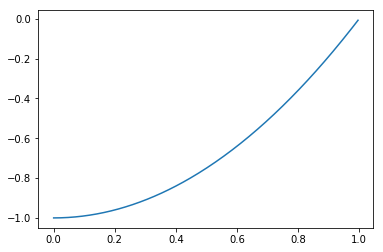

In [233]:
x = []
values = []
for i in range(0, 255):
    val = float(i)/255.0
    x.append(val)
#     values.append(np.log(val + 1.0))
    values.append(val**2 - 1.0)
plt.plot(x, values)